<a href="https://colab.research.google.com/github/Fresno777/PandasGUI/blob/master/example_Liu_et_al_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example to illustrate how to use WQChartPy

This Colab notebook was created to illustrated how to use WQChartPy by using the example geochemical dataset taken from Liu et al. (2021). This dataset contains a total of 327 groundwater samples. Liu et al. (2021) used this dataset to to reveal spatio-temporal patterns and controlling factors of groundwater geochemistry in Dagu River Basin, China.

In [ ]:
! pip install wqchartpy

     |████████████████████████████████| 21.7 MB 1.4 MB/s 
     |████████████████████████████████| 11.2 MB 17.7 MB/s 
     |████████████████████████████████| 895 kB 64.3 MB/s 
  Created wheel for wqchartpy: filename=wqchartpy-0.1.8-py3-none-any.whl size=46183 sha256=b11b6af18243e3972ad8e6a7fb7eadcd6b20ca6f449d3f460db2ea00eba88be4
  Stored in directory: /root/.cache/pip/wheels/ed/fb/32/230bfcb14b268c43c85ab8718ed0b57f7c87a70fb254905b1a
Successfully built wqchartpy
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


## Set data path

In [ ]:
# Set the data path
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
data_path = '/content/drive/MyDrive/Colab Notebooks/WQChartPy_examples/data/'

Mounted at /content/drive


## Import modules

In [ ]:
# Import modules
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt

## Load data

In [ ]:
# Load the template data
raw_df = pd.read_csv(data_path + 'data_Liu_et_al_2021.csv')

# Show the data
raw_df

,ID,ShortID,X,Y,Longitude,Latitude,SY,SM,pH,Alk,Hardness,TDS,Ca,Mg,K,Na,KNa,Cl,SO4,HCO3,NO3,F,Unnamed: 22
0,3702810206,W17,4030063,244248,120.150528,36.367219,2001,6,8.00,377.29,447.50,1895.72,63.76,70.00,20.50,405.00,425.50,271.32,588.18,460.06,0.10,0.65,NaN
1,3702810206,W17,4030063,244248,120.150528,36.367219,2002,9,7.00,270.86,480.43,1135.67,91.54,61.16,16.39,211.56,227.95,215.49,352.73,330.26,7.24,0.34,NaN
2,3702810206,W17,4030063,244248,120.150528,36.367219,2003,6,7.96,277.25,510.36,1287.24,121.33,50.34,10.00,186.00,196.00,152.39,394.97,338.02,17.62,0.55,NaN
3,3702810206,W17,4030063,244248,120.150528,36.367219,2013,7,8.40,250.48,536.58,1855.96,63.71,91.67,33.00,405.00,438.00,593.70,351.79,280.75,0.49,0.25,NaN
4,3702810206,W17,4030063,244248,120.150528,36.367219,2013,10,7.28,374.59,225.66,1045.62,31.61,35.63,17.91,206.20,224.11,82.09,193.63,456.73,6.58,0.25,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,3702850115,W5,4063952,260218,120.317797,36.676494,2015,9,8.28,323.47,496.16,1140.45,143.06,33.72,25.52,103.57,129.09,136.03,124.37,394.40,153.19,0.23,NaN
374,3702850115,W5,4063952,260218,120.317797,36.676494,2016,6,8.35,229.91,391.17,965.73,104.36,31.72,27.31,100.87,128.18,134.39,123.08,267.90,163.18,0.03,NaN
375,3702850115,W5,4063952,260218,120.317797,36.676494,2016,11,7.60,197.21,576.47,1425.66,165.43,39.69,0.43,91.51,91.94,251.18,242.10,240.49,394.42,NaN,NaN
376,3702850115,W5,4063952,260218,120.317797,36.676494,2017,7,8.07,NaN,847.69,1424.00,226.32,68.64,4.95,83.90,88.85,197.86,295.14,113.64,467.44,0.10,NaN


One may note that this dataset is the raw data. We will perform the Clustering analysis by following Liu et al. (2021) first and show below how to process the raw data and the use WQChartPy to display the samples.

## Clustering the data using HCA¶

### Data preprocessing

In [ ]:
# Parameters included for HCA including the ID
pars = ['ID', 'ShortID', 'SY', 'SM', 'TDS', 'pH', 'Ca', 'Mg', 'K', 'Na', 'KNa', 'Cl','SO4','HCO3', 'NO3', 'F']
df = raw_df[pars].copy()

In [ ]:
# Check the charge balance error (CBE)
Ca   = 40
Mg   = 24
K    = 39
Na   = 23
Cl   = 35.5
SO4  = 96
HCO3 = 61
NO3  = 62
F    = 19

CBE_cations = df['Ca'] * 2 / Ca + df['Mg'] * 2 / Mg + df['K'] * 1 / K + df['Na'] * 1 / Na

CBE_anions= df['Cl'] * 1 / Cl + df['SO4'] * 2 / SO4 + df['HCO3'] * 1/ HCO3 + df['NO3'] * 1 / NO3 + df['F'] * 1 / 19
CBE = abs((CBE_cations - CBE_anions) / (CBE_cations + CBE_anions)) * 100

print('--> Number of samples with CBE greater than 10% =', sum(CBE>=10))
df['CBE'] = CBE

df.loc[CBE>=10, ['ID', 'ShortID', 'SY', 'SM', 'CBE']]

--> Number of samples with CBE greater than 10% = 8


,ID,ShortID,SY,SM,CBE
118,3702810267,W13,2016,6,11.061959
119,3702810267,W13,2016,11,38.674816
124,3702820277,W12,2013,7,15.514976
176,3702820348,W10,2016,6,10.633847
195,3702820363,W7,2014,12,10.727036
314,3702830378,W6,2016,6,10.579574
337,3702830431,W4,2016,6,10.902498
346,3702830459,W1,2014,8,16.228160


In [ ]:
# Drop the nan and Exclude the samples with CBE>10%
tmp_df = df[(df['CBE']<=10) | (df['CBE'].isnull())][['ID', 'ShortID', 'SY', 'SM', 'pH', 'Ca', 'Mg', 'KNa', 'Cl','SO4','HCO3', 'NO3', 'F', 'TDS']].dropna(axis=0, how='any')

In [ ]:
# The number of the remaining samples
print('Number of samples: ', tmp_df.shape[0])

Number of samples:  327


In [ ]:
# Print the statistical information ofthe remaining samples
tmp_df[['pH', 'Ca', 'Mg', 'KNa', 'Cl','SO4','HCO3', 'NO3', 'F', 'TDS']].describe()

,pH,Ca,Mg,KNa,Cl,SO4,HCO3,NO3,F,TDS
count,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000,327.000000
mean,7.615107,131.493639,45.826330,152.543609,182.334985,225.496789,247.520275,147.146575,0.424850,1137.870031
std,0.460667,53.841371,20.377845,162.928036,175.744758,144.944922,130.433325,139.902391,0.404052,469.483984
min,5.900000,6.680000,3.700000,10.700000,43.100000,36.700000,24.560000,0.100000,0.010000,426.000000
25%,7.300000,95.170000,32.070000,71.155000,115.130000,126.500000,154.760000,26.850000,0.200000,868.050000
50%,7.600000,127.410000,41.200000,109.000000,138.000000,177.000000,222.200000,103.720000,0.280000,1071.220000
75%,7.950000,167.480000,56.035000,173.950000,180.555000,277.370000,310.350000,226.205000,0.470000,1282.000000
max,8.900000,343.800000,140.710000,1168.720000,1658.630000,749.930000,729.220000,622.030000,2.200000,3824.020000


In [ ]:
# Data transformation
X_df = np.log(tmp_df[['pH', 'Ca', 'Mg', 'KNa', 'Cl','SO4','HCO3', 'NO3', 'F']])

# Standardization 
X = X_df.values
rescaledX = StandardScaler().fit_transform(X)

In [ ]:
# Print the size of final data matrix
n_samples, n_parameters = rescaledX.shape
print('Number of samples:', n_samples, '\nNumber of variables:', n_parameters)

Number of samples: 327 
Number of variables: 9


In [ ]:
# Get ID and other info for the samples
Y_df = tmp_df[['ID', 'ShortID', 'SY', 'SM', 'pH', 'Ca', 'Mg', 'KNa', 'Cl','SO4','HCO3', 'NO3', 'F', 'TDS']]

### Clustering the geochemical data by using HCA

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator


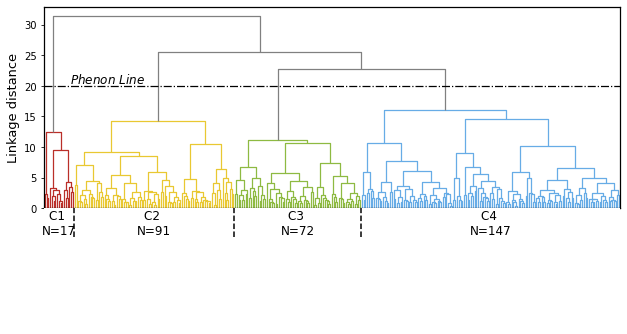

In [ ]:
# Ward method
import matplotlib
from scipy.cluster import hierarchy

# Override the default linewidth.
matplotlib.rcParams['lines.linewidth'] = 1.25

Z = hierarchy.linkage(rescaledX, method='ward', metric='euclidean')

# Set the location of phenon line
max_d = 20  

# Figure settings of the dendrogram
fig = plt.figure(figsize=(10, 8))

# Axis settings
left, bottom, width, height = 0.1, 0.35, 0.8, 0.35
ax1 = fig.add_axes([left, bottom, width, height])

# Customize the colors of the nine clusters
colors=['#BA2F29', '#E9C832', '#8EBA42', '#67ACE6']
hierarchy.set_link_color_palette(colors)

# Plot the dendrogram
hierarchy.dendrogram(Z, leaf_rotation=90, leaf_font_size=0, 
                     color_threshold=max_d, above_threshold_color='grey')
hierarchy.set_link_color_palette(None)
ax1.axhline(y=max_d, linestyle='-.', color='k', lw=1.25) 
ax1.set_ylabel('Linkage distance', fontsize=13)
ax1.set_yticklabels([0, 5, 10, 15, 20, 25, 30, 35], fontsize=10)
ax1.set_xticks([])
ax1.spines['top'].set_linewidth(1.25)
ax1.spines['bottom'].set_linewidth(1.25)
ax1.spines['left'].set_linewidth(1.25)
ax1.spines['right'].set_linewidth(1.25)
ax1.text(150, 20.5, '$Phenon$' + ' ' + '$Line$', fontsize=12)

# Calculate number of clusters under the linkage distance of max_d
n_clusters = np.max(np.unique(hierarchy.fcluster(Z, max_d, criterion='distance')))

# Calculate the number of samples for each cluster
cluster_size = [np.sum(hierarchy.fcluster(Z, max_d, criterion='distance')==i + 1) for i in range(n_clusters)]

# The bottom figure showing the cluster names
left, bottom, width, height = 0.1, 0.15, 0.8, 0.2
ax2 = fig.add_axes([left, bottom, width, height])
ax2.set_xlim(0, n_samples * 10)
ax2.set_ylim(0, 2)


# Dot line to split each cluster 
cum_cluster_szie = np.cumsum(cluster_size) * 10
for i in range(n_clusters - 1):
    ax2.plot([cum_cluster_szie[i], cum_cluster_szie[i]], [1.5, 2.0], linestyle='--', color='k', lw=1.5) 

ax2.set_xticks([])
ax2.set_yticks([])
    
ax2.spines['top'].set_color('none')
ax2.spines['bottom'].set_color('none')
ax2.spines['left'].set_color('none')
ax2.spines['right'].set_color('none')

ax2.text(0                   + (cum_cluster_szie[0] -                   0) / 2, 1.5, 'C1 \nN=%d' %cluster_size[0], ha='center', va='bottom', fontsize=12)
ax2.text(cum_cluster_szie[0] + (cum_cluster_szie[1] - cum_cluster_szie[0]) / 2, 1.5, 'C2 \nN=%d' %cluster_size[1], ha='center', va='bottom', fontsize=12)
ax2.text(cum_cluster_szie[1] + (cum_cluster_szie[2] - cum_cluster_szie[1]) / 2, 1.5, 'C3 \nN=%d' %cluster_size[2], ha='center', va='bottom', fontsize=12)
ax2.text(cum_cluster_szie[2] + (cum_cluster_szie[3] - cum_cluster_szie[2]) / 2, 1.5, 'C4 \nN=%d' %cluster_size[3], ha='center', va='bottom', fontsize=12)

plt.show()

In [ ]:
# Save the clustering results
Y_df['SCI'] = hierarchy.fcluster(Z, max_d, criterion='distance')
cluster_ids = Y_df['SCI'].values
print('Number of clusters:', n_clusters)
print('Samples in each cluster:', cluster_size)
print('Total samples:', np.sum(cluster_size))

Number of clusters: 4
Samples in each cluster: [17, 91, 72, 147]
Total samples: 327


In [ ]:
# Show Y_df
Y_df

,ID,ShortID,SY,SM,pH,Ca,Mg,KNa,Cl,SO4,HCO3,NO3,F,TDS,SCI
0,3702810206,W17,2001,6,8.00,63.76,70.00,425.50,271.32,588.18,460.06,0.10,0.65,1895.72,1
1,3702810206,W17,2002,9,7.00,91.54,61.16,227.95,215.49,352.73,330.26,7.24,0.34,1135.67,3
2,3702810206,W17,2003,6,7.96,121.33,50.34,196.00,152.39,394.97,338.02,17.62,0.55,1287.24,2
3,3702810206,W17,2013,7,8.40,63.71,91.67,438.00,593.70,351.79,280.75,0.49,0.25,1855.96,1
4,3702810206,W17,2013,10,7.28,31.61,35.63,224.11,82.09,193.63,456.73,6.58,0.25,1045.62,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,3702850115,W5,2015,4,7.84,195.34,69.06,126.84,214.15,284.82,198.71,368.61,0.25,1494.75,2
373,3702850115,W5,2015,9,8.28,143.06,33.72,129.09,136.03,124.37,394.40,153.19,0.23,1140.45,3
374,3702850115,W5,2016,6,8.35,104.36,31.72,128.18,134.39,123.08,267.90,163.18,0.03,965.73,4
376,3702850115,W5,2017,7,8.07,226.32,68.64,88.85,197.86,295.14,113.64,467.44,0.10,1424.00,4


### Organize the data into WQChartPy required formats

In [ ]:
format_df = pd.DataFrame()
format_df['Sample'] = Y_df['ShortID'].map(str) + '_' + Y_df['SY'].map(str) + '_'  + Y_df['SM'].map(str)
format_df['Label'] = 'C' + Y_df['SCI'].map(str)

format_df.loc[format_df['Label']=='C1', 'Color'] = '#BA2F29'
format_df.loc[format_df['Label']=='C2', 'Color'] = '#E9C832'
format_df.loc[format_df['Label']=='C3', 'Color'] = '#89C667'
format_df.loc[format_df['Label']=='C4', 'Color'] = '#67ACE6'
format_df['Marker'] = 'o'
format_df['Size'] = 20
format_df['Alpha'] = 0.6

format_df['pH'] = Y_df['pH']
format_df['Ca'] = Y_df['Ca']
format_df['Mg'] = Y_df['Mg']
# Since ther are missing values of K concentration,
#   we use KNa concentration represent Na and set K concentration to 0
format_df['Na'] = Y_df['KNa']              
format_df['K'] = 0

format_df['HCO3'] = Y_df['HCO3']
format_df['CO3'] = 0
format_df['Cl'] = Y_df['Cl']
format_df['SO4'] = Y_df['SO4']
format_df['TDS'] = Y_df['TDS']

# Reset the index
format_df.reset_index(inplace=True, drop=True)



Trilinear Piper plot created. Saving it to /content 



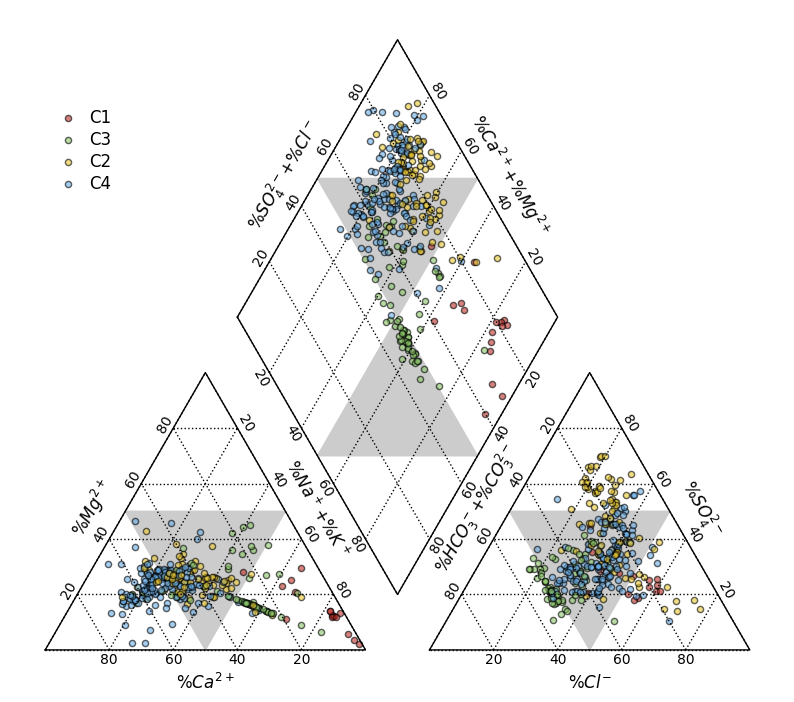

In [ ]:
# Import WQChartPy
from wqchartpy import triangle_piper

# Draw the diagram
triangle_piper.plot(format_df, unit='mg/L', figname='triangle Piper diagram', figformat='jpg')